In [1]:
# set variables and file paths

model_name = "meta-llama/Llama-3.3-70B-Instruct"
output_path = "output/Llama_3.3_70B_zs_Debagree_2Labels_sample.csv"

# **Llama-3.3-70B-Instruct**
## **Zero Shot Classification of 2 Labels --> disagree or no disagree**
## **Prompt Comparison**

* Ran on sample of 10.000 interactions
* Purpose: Compare two vs. three labels





In [2]:
# install packages
!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl
!pip install pyarrow==18.1.0
!pip install evaluate
!pip install datasets 

In [3]:
# import packages

import numpy as np
import pandas as pd
import os
import random
import evaluate
import functools # ??
from tqdm import tqdm
import bitsandbytes as bnb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import is_bf16_supported

from datasets import Dataset, DatasetDict
from peft import LoraConfig, PeftConfig, prepare_model_for_kbit_training, get_peft_model

from trl import SFTTrainer
from trl import setup_chat_format

import transformers
from transformers import (AutoModelForCausalLM,
                          AutoModelForSequenceClassification,
                        AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                            Trainer,
                            DataCollatorWithPadding,
                          pipeline, 
                          logging)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix,
                            f1_score, balanced_accuracy_score)
from sklearn.metrics import precision_recall_fscore_support


import ast
from huggingface_hub import login

In [4]:

print(torch.cuda.is_available())
torch.cuda.empty_cache()

# check GPU's capacity for quantization
print(torch.cuda.get_device_name(0))
print(is_bf16_supported())


True
NVIDIA H100 80GB HBM3
True


## **Authenticate for Hugging Face**

In [5]:
os.getcwd()

'/home/jovyan/llama_final/Causal/two_label_debagree'

In [6]:
# Hugging face access

with open("../../../login/hf_key.txt", 'r') as f: 
    HF_TOKEN = str(f.read())
    
login(token = HF_TOKEN)

## **Data**

In [7]:
# loading the data

data = pd.read_csv("../../../data/debagree_new_preprocessing_com_rep.csv")
data = data[["label", "body_parent", "body_child", "msg_id_parent", "msg_id_child", "subreddit", "datetime", "exact_time"]].sort_values(by = "exact_time").reset_index(drop = True)

# keep integer labels
data['target'] = data['label']

# for readability, recode labels
int_to_label = {2: "agree", 1 : "neutral", 0 : "disagree"}
label_to_int = {"agree" : 2, "neutral" : 1, "disagree" : 0}
data.replace({"label": int_to_label}, inplace = True)

data

,label,body_parent,body_child,msg_id_parent,msg_id_child,subreddit,datetime,exact_time,target
0,neutral,"I live in rural Saskatchewan, Canada. We have ...",I'm in NE USA we've had 3 in two years...all e...,cnddov1,cndj2gv,climate,03/01/2015 23:18,1420327135,1
1,neutral,"I live in rural Saskatchewan, Canada. We have ...",One hundred year flood just means a one in one...,cnddov1,cndkpy7,climate,04/01/2015 00:10,1420330231,1
2,neutral,Convince her of what? That it's happening or t...,That anthropocentric climate change is actuall...,cndnlrd,cndnsxt,climate,04/01/2015 01:45,1420335952,1
3,disagree,I think this prediction is about as valid as s...,It's January. Literally no one said it would b...,cndl5x4,cndybsy,climate,04/01/2015 08:01,1420358465,0
4,disagree,"Mann hasn't been honest in decades, so I'm cur...",There have been a dozen re-constructions of Ma...,cne462t,cne89ej,climate,04/01/2015 17:45,1420393544,0
...,...,...,...,...,...,...,...,...,...
42838,neutral,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...,gyo197v,gyotff1,Republican,19/05/2021 12:36,1621427788,1
42839,agree,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop....",gynfsu4,gyp3u39,democrats,19/05/2021 13:56,1621432578,2
42840,agree,Why don't I see ads holding Republicans accoun...,"Yeah, I agree with the goal of this post but n...",gyn6nzm,gyp5vzw,democrats,19/05/2021 14:11,1621433471,2
42841,agree,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold...",gyp71o7,gyp7en6,BlackLivesMatter,19/05/2021 14:21,1621434116,2


### Sample interactions, keeping shares of subreddits and labels



In [8]:

def stratified_sample_target_size(df, subreddit_col, label_col, total_size):
    """
    Perform a two-level stratified sample:
    - First by subreddit (in proportion to their frequency)
    - Then by label within each subreddit (preserving label distribution)
    
    Returns exactly `total_size` rows.
    """
    # subreddit proportions
    subreddit_dist = df[subreddit_col].value_counts(normalize=True)

    sampled_rows = []

    for subreddit, subreddit_prop in subreddit_dist.items():
        # nr rows to sample from this subreddit
        subreddit_n = int(round(total_size * subreddit_prop))
        sub_df = df[df[subreddit_col] == subreddit]

        # within subreddit, keep label distribution
        label_dist = sub_df[label_col].value_counts(normalize=True)

        for label, label_prop in label_dist.items():
            label_n = int(round(subreddit_n * label_prop))
            label_df = sub_df[sub_df[label_col] == label]
            
            # Sample, but make sure we don't sample more than we have
            actual_n = min(label_n, len(label_df))
            if actual_n > 0:
                sampled_rows.append(label_df.sample(n=actual_n, random_state=42))

    # Combine all, shuffle, and trim to exactly `total_size`
    final_df = pd.concat(sampled_rows).sample(frac=1, random_state=42).reset_index(drop=True)

    # Ensure final size matches (if over, just trim)
    return final_df.iloc[:total_size]


In [9]:
sample_df = stratified_sample_target_size(data, "subreddit", "label", 10000)
sample_df

,label,body_parent,body_child,msg_id_parent,msg_id_child,subreddit,datetime,exact_time,target
0,agree,"They shouldn't be winning elections, that's fo...",I agree with this. They obviously shouldn't be...,gqak9tq,gqalvak,democrats,09/03/2021 04:29,1615264154,2
1,agree,This tells me one thing. COVID was politicized...,Ahh yes planned by the whole world to cover up...,ghrt3ay,ghw66nh,Republican,03/01/2021 03:02,1609642942,2
2,agree,"So, the mini-deals are being discussed because...",So believes the EU. And seeing as they hold al...,gfask7y,gfav46i,Brexit,10/12/2020 17:23,1607620990,2
3,agree,My sister is a type one diabetic and a biden s...,Let's be honest. Trump could have directed to ...,gyj4rst,gyk1wwh,Republican,18/05/2021 11:30,1621337452,2
4,disagree,You guys are so stupid. The difference is that...,One of them had the flu for a couple days? Whi...,g7xuo23,g7y3wdy,Republican,06/10/2020 22:56,1602024961,0
...,...,...,...,...,...,...,...,...,...
9995,agree,Just like he rigged the Supreme court by not a...,I despise him for doing this. This man has bee...,fgdpkdc,fgdsys2,democrats,02/02/2020 23:35,1580686536,2
9996,neutral,He needs to grow up fast. Right out of the gat...,I don't keep up with him but what did he do.,gb4idfe,gb4ofe7,Republican,04/11/2020 16:28,1604507309,1
9997,agree,I just got banned on for stating that same fa...,had this bs as a hotpost today. It irks me th...,fogwj8w,foie0e3,Republican,25/04/2020 03:14,1587784461,2
9998,agree,"I was liberal until I graduated college, moved...",Yeah New York scares me. That and California. ...,g82yc73,g830mfp,Republican,08/10/2020 05:34,1602135247,2


## **Load the Model**



### Quantization for QLoRA

In [10]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4 bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

### **Load the Model**

* AutoModelForCausalLM 

In [11]:
torch.cuda.empty_cache()

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = quantization_config
)

model

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 8192)
    (layers): ModuleList(
      (0-79): 80 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=8192, out_features=8192, bias=False)
          (k_proj): Linear4bit(in_features=8192, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=8192, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=8192, out_features=8192, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=8192, out_features=28672, bias=False)
          (up_proj): Linear4bit(in_features=8192, out_features=28672, bias=False)
          (down_proj): Linear4bit(in_features=28672, out_features=8192, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((8192,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((8192,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((819

## **Tokenizer**

### Since LLAMA3 pre-training doesn't have EOS token
* Set the pad_token_id to eos_token_id
* Set pad token ot eos_token

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space = True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

### Update Model Configurations

In [13]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_pt = 1

## **Generate Prompts**

In [14]:
# make text

def create_training_data(data):

    result = []

    for idx, row in data.iterrows():
        system_prompt = """You are a classification chatbot. Analyze a Reddit comment and its reply. Determine if the reply explicitly and unambiguously disagrees with the comment. Respond with 'disagree' for clear disagreement or 'no_disagreement' if the reply adds information, qualifies the statement, offers an alternative perspective, or leaves any doubt about disagreement. Your response must strictly be 'disagree' or 'no_disagreement'."""
        comment = row["body_parent"]
        reply = row["body_child"]
        label = row["label"]
        target = row["target"]
        
        comment_id = row["msg_id_parent"]
        reply_id = row["msg_id_child"]
        subreddit = row["subreddit"]
        
        result.append({'system_prompt' : system_prompt, 'comment' : comment, 'reply': reply, 'label' : label, 'target' : target, 'msg_id_parent' : comment_id, 'msg_id_child' : reply_id, 'subreddit' : subreddit})
    
    return result

# save data
df = pd.DataFrame(create_training_data(sample_df))
df

,system_prompt,comment,reply,label,target,msg_id_parent,msg_id_child,subreddit
0,You are a classification chatbot. Analyze a Re...,"They shouldn't be winning elections, that's fo...",I agree with this. They obviously shouldn't be...,agree,2,gqak9tq,gqalvak,democrats
1,You are a classification chatbot. Analyze a Re...,This tells me one thing. COVID was politicized...,Ahh yes planned by the whole world to cover up...,agree,2,ghrt3ay,ghw66nh,Republican
2,You are a classification chatbot. Analyze a Re...,"So, the mini-deals are being discussed because...",So believes the EU. And seeing as they hold al...,agree,2,gfask7y,gfav46i,Brexit
3,You are a classification chatbot. Analyze a Re...,My sister is a type one diabetic and a biden s...,Let's be honest. Trump could have directed to ...,agree,2,gyj4rst,gyk1wwh,Republican
4,You are a classification chatbot. Analyze a Re...,You guys are so stupid. The difference is that...,One of them had the flu for a couple days? Whi...,disagree,0,g7xuo23,g7y3wdy,Republican
...,...,...,...,...,...,...,...,...
9995,You are a classification chatbot. Analyze a Re...,Just like he rigged the Supreme court by not a...,I despise him for doing this. This man has bee...,agree,2,fgdpkdc,fgdsys2,democrats
9996,You are a classification chatbot. Analyze a Re...,He needs to grow up fast. Right out of the gat...,I don't keep up with him but what did he do.,neutral,1,gb4idfe,gb4ofe7,Republican
9997,You are a classification chatbot. Analyze a Re...,I just got banned on for stating that same fa...,had this bs as a hotpost today. It irks me th...,agree,2,fogwj8w,foie0e3,Republican
9998,You are a classification chatbot. Analyze a Re...,"I was liberal until I graduated college, moved...",Yeah New York scares me. That and California. ...,agree,2,g82yc73,g830mfp,Republican


In [15]:
 
def make_chat_prompt(row):

    temp = [] 
    temp.append({"role": "system", "content": row['system_prompt']})
    temp.append({"role": "user", "content": f"comment: '{row['comment']}' ; reply: '{row['reply']}'"})

    prompt = tokenizer.apply_chat_template(temp, tokenize=False, add_generation_prompt=True )
    
    return prompt

df['chat_prompt'] = df.apply(lambda row: make_chat_prompt(row), axis = 1)
df['chat_prompt'][0]

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nYou are a classification chatbot. Analyze a Reddit comment and its reply. Determine if the reply explicitly and unambiguously disagrees with the comment. Respond with 'disagree' for clear disagreement or 'no_disagreement' if the reply adds information, qualifies the statement, offers an alternative perspective, or leaves any doubt about disagreement. Your response must strictly be 'disagree' or 'no_disagreement'.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\ncomment: 'They shouldn't be winning elections, that's for sure, but I'm not sure how to angle a ban. All that would do is fail when it hit the Supreme Court and give them fuel for their martyr complex' ; reply: 'I agree with this. They obviously shouldn't be holding positions of power, but just outright banning an idea, even a horrible and dangerous one, just won't fly in the supreme court, especi

In [16]:
def make_plain_prompt(row):
    prompt = (f"{row['system_prompt']}\n\n" 
              f"Comment: \"{row['comment']}\"\n" 
                f"Reply: \"{row['reply']}\"\n" 
                f"Answer:")
    

    return prompt

df['plain_prompt'] = df.apply(lambda row: make_plain_prompt(row), axis = 1)
df

df['plain_prompt'][0]

'You are a classification chatbot. Analyze a Reddit comment and its reply. Determine if the reply explicitly and unambiguously disagrees with the comment. Respond with \'disagree\' for clear disagreement or \'no_disagreement\' if the reply adds information, qualifies the statement, offers an alternative perspective, or leaves any doubt about disagreement. Your response must strictly be \'disagree\' or \'no_disagreement\'.\n\nComment: "They shouldn\'t be winning elections, that\'s for sure, but I\'m not sure how to angle a ban. All that would do is fail when it hit the Supreme Court and give them fuel for their martyr complex"\nReply: "I agree with this. They obviously shouldn\'t be holding positions of power, but just outright banning an idea, even a horrible and dangerous one, just won\'t fly in the supreme court, especially not with the current justices. I think everyone agrees something should be done to get rid of white supremacists, but it\'s a difficult problem to sort out in a w

In [17]:
def make_hybrid_prompt(row):
    
    prompt = (
        f"<|begin_of_text|>SYSTEM: {row['system_prompt']}\n"
        f"USER: Comment: \"{row['comment']}\" Reply: \"{row['reply']}\"\n"
        f"ASSISTANT: Classification:"
    )
    
    return prompt



df['hybrid_prompt'] = df.apply(lambda row: make_hybrid_prompt(row), axis = 1)
df

df['hybrid_prompt'][0]

'<|begin_of_text|>SYSTEM: You are a classification chatbot. Analyze a Reddit comment and its reply. Determine if the reply explicitly and unambiguously disagrees with the comment. Respond with \'disagree\' for clear disagreement or \'no_disagreement\' if the reply adds information, qualifies the statement, offers an alternative perspective, or leaves any doubt about disagreement. Your response must strictly be \'disagree\' or \'no_disagreement\'.\nUSER: Comment: "They shouldn\'t be winning elections, that\'s for sure, but I\'m not sure how to angle a ban. All that would do is fail when it hit the Supreme Court and give them fuel for their martyr complex" Reply: "I agree with this. They obviously shouldn\'t be holding positions of power, but just outright banning an idea, even a horrible and dangerous one, just won\'t fly in the supreme court, especially not with the current justices. I think everyone agrees something should be done to get rid of white supremacists, but it\'s a difficul

In [18]:
df

,system_prompt,comment,reply,label,target,msg_id_parent,msg_id_child,subreddit,chat_prompt,plain_prompt,hybrid_prompt
0,You are a classification chatbot. Analyze a Re...,"They shouldn't be winning elections, that's fo...",I agree with this. They obviously shouldn't be...,agree,2,gqak9tq,gqalvak,democrats,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
1,You are a classification chatbot. Analyze a Re...,This tells me one thing. COVID was politicized...,Ahh yes planned by the whole world to cover up...,agree,2,ghrt3ay,ghw66nh,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
2,You are a classification chatbot. Analyze a Re...,"So, the mini-deals are being discussed because...",So believes the EU. And seeing as they hold al...,agree,2,gfask7y,gfav46i,Brexit,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
3,You are a classification chatbot. Analyze a Re...,My sister is a type one diabetic and a biden s...,Let's be honest. Trump could have directed to ...,agree,2,gyj4rst,gyk1wwh,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
4,You are a classification chatbot. Analyze a Re...,You guys are so stupid. The difference is that...,One of them had the flu for a couple days? Whi...,disagree,0,g7xuo23,g7y3wdy,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
...,...,...,...,...,...,...,...,...,...,...,...
9995,You are a classification chatbot. Analyze a Re...,Just like he rigged the Supreme court by not a...,I despise him for doing this. This man has bee...,agree,2,fgdpkdc,fgdsys2,democrats,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
9996,You are a classification chatbot. Analyze a Re...,He needs to grow up fast. Right out of the gat...,I don't keep up with him but what did he do.,neutral,1,gb4idfe,gb4ofe7,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
9997,You are a classification chatbot. Analyze a Re...,I just got banned on for stating that same fa...,had this bs as a hotpost today. It irks me th...,agree,2,fogwj8w,foie0e3,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
9998,You are a classification chatbot. Analyze a Re...,"I was liberal until I graduated college, moved...",Yeah New York scares me. That and California. ...,agree,2,g82yc73,g830mfp,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...


### Sample 1.000 rows for prompt comparison

In [19]:
df_sample = df.sample(n = 1000, random_state = 42).reset_index(drop=True)

df_sample

,system_prompt,comment,reply,label,target,msg_id_parent,msg_id_child,subreddit,chat_prompt,plain_prompt,hybrid_prompt
0,You are a classification chatbot. Analyze a Re...,"I hope after Biden takes over on Jan 20th, he ...",It's not the pee tape. It's video from one of ...,disagree,0,ggggrpa,gggv1ic,democrats,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
1,You are a classification chatbot. Analyze a Re...,They think they can force morality on all lawy...,"No, they're targeting their message at the rec...",disagree,0,fenqhwf,fesjcsy,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
2,You are a classification chatbot. Analyze a Re...,That must mean there is something of value the...,China does this over petty shit. Norway export...,agree,2,foqmzt9,forf6we,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
3,You are a classification chatbot. Analyze a Re...,I hate how this has turned into a political is...,I'm glad I've met someone in reddit who's not ...,agree,2,fo8vpi5,fo8vzaj,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
4,You are a classification chatbot. Analyze a Re...,Trump opened the road for this type of fuckers...,I know it's a cliche but you couldn't make thi...,agree,2,eopu1sa,eopur9g,Brexit,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
...,...,...,...,...,...,...,...,...,...,...,...
995,You are a classification chatbot. Analyze a Re...,I'm really amazed at the polarization. I look ...,You manage to still have friends from both pol...,disagree,0,g4ditz2,g4dt9ap,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
996,You are a classification chatbot. Analyze a Re...,Some very choice wires from the article Temper...,24.... feet? My god. I honestly though it was ...,neutral,1,evpzd2d,evs1eqj,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
997,You are a classification chatbot. Analyze a Re...,Personally if I was the EU I would trade fish ...,Not really. Thats what tariffs and non tariff ...,disagree,0,g9k7f3l,g9kyjst,Brexit,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...
998,You are a classification chatbot. Analyze a Re...,Trump went way beyond undoing Obama's climate ...,How can a president become so powerful to roll...,disagree,0,g2cvi1j,g2dvssg,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...


***

## **Apply model**

In [20]:

# Define batch size
batch_size = 32

# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Function to process one prompt column
def generate_predictions(df, prompt_column_name, output_column_name):
    all_outputs = []

    # Get all prompts for the selected strategy
    prompts = df[prompt_column_name].tolist()

    for i in tqdm(range(0, len(prompts), batch_size), desc=f"Generating for {prompt_column_name}"):
        batch_prompts = prompts[i:i + batch_size]

        # Tokenize (skip apply_chat_template here — it's already done)
        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate predictions
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                num_return_sequences=1,
                do_sample=False  # Optional: make deterministic
            )

        # Decode and collect
        decoded = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        all_outputs.extend(decoded)

    # Add raw output to the dataframe
    df[output_column_name] = all_outputs

    # Normalize and clean up (extract just 'agree' or 'disagree' if possible)
    df[output_column_name] = df[output_column_name].str.lower().str.strip()

    return df


In [21]:
# chat
sample_df = generate_predictions(df_sample, "chat_prompt", "predicted_chat")


Generating for chat_prompt:   0%|          | 0/32 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Generating for chat_prompt: 100%|██████████| 32/32 [02:56<00:00,  5.53s/it]


,system_prompt,comment,reply,label,target,msg_id_parent,msg_id_child,subreddit,chat_prompt,plain_prompt,hybrid_prompt,predicted_chat
0,You are a classification chatbot. Analyze a Re...,"I hope after Biden takes over on Jan 20th, he ...",It's not the pee tape. It's video from one of ...,disagree,0,ggggrpa,gggv1ic,democrats,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...
1,You are a classification chatbot. Analyze a Re...,They think they can force morality on all lawy...,"No, they're targeting their message at the rec...",disagree,0,fenqhwf,fesjcsy,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...
2,You are a classification chatbot. Analyze a Re...,That must mean there is something of value the...,China does this over petty shit. Norway export...,agree,2,foqmzt9,forf6we,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...
3,You are a classification chatbot. Analyze a Re...,I hate how this has turned into a political is...,I'm glad I've met someone in reddit who's not ...,agree,2,fo8vpi5,fo8vzaj,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...
4,You are a classification chatbot. Analyze a Re...,Trump opened the road for this type of fuckers...,I know it's a cliche but you couldn't make thi...,agree,2,eopu1sa,eopur9g,Brexit,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...
...,...,...,...,...,...,...,...,...,...,...,...,...
995,You are a classification chatbot. Analyze a Re...,I'm really amazed at the polarization. I look ...,You manage to still have friends from both pol...,disagree,0,g4ditz2,g4dt9ap,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...
996,You are a classification chatbot. Analyze a Re...,Some very choice wires from the article Temper...,24.... feet? My god. I honestly though it was ...,neutral,1,evpzd2d,evs1eqj,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...
997,You are a classification chatbot. Analyze a Re...,Personally if I was the EU I would trade fish ...,Not really. Thats what tariffs and non tariff ...,disagree,0,g9k7f3l,g9kyjst,Brexit,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...
998,You are a classification chatbot. Analyze a Re...,Trump went way beyond undoing Obama's climate ...,How can a president become so powerful to roll...,disagree,0,g2cvi1j,g2dvssg,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...


In [22]:
sample_df = generate_predictions(df_sample, "plain_prompt", "predicted_plain")


Generating for plain_prompt:   0%|          | 0/32 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Generating for plain_prompt: 100%|██████████| 32/32 [03:45<00:00,  7.05s/it]


,system_prompt,comment,reply,label,target,msg_id_parent,msg_id_child,subreddit,chat_prompt,plain_prompt,hybrid_prompt,predicted_chat,predicted_plain
0,You are a classification chatbot. Analyze a Re...,"I hope after Biden takes over on Jan 20th, he ...",It's not the pee tape. It's video from one of ...,disagree,0,ggggrpa,gggv1ic,democrats,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...
1,You are a classification chatbot. Analyze a Re...,They think they can force morality on all lawy...,"No, they're targeting their message at the rec...",disagree,0,fenqhwf,fesjcsy,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...
2,You are a classification chatbot. Analyze a Re...,That must mean there is something of value the...,China does this over petty shit. Norway export...,agree,2,foqmzt9,forf6we,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...
3,You are a classification chatbot. Analyze a Re...,I hate how this has turned into a political is...,I'm glad I've met someone in reddit who's not ...,agree,2,fo8vpi5,fo8vzaj,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...
4,You are a classification chatbot. Analyze a Re...,Trump opened the road for this type of fuckers...,I know it's a cliche but you couldn't make thi...,agree,2,eopu1sa,eopur9g,Brexit,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,You are a classification chatbot. Analyze a Re...,I'm really amazed at the polarization. I look ...,You manage to still have friends from both pol...,disagree,0,g4ditz2,g4dt9ap,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...
996,You are a classification chatbot. Analyze a Re...,Some very choice wires from the article Temper...,24.... feet? My god. I honestly though it was ...,neutral,1,evpzd2d,evs1eqj,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...
997,You are a classification chatbot. Analyze a Re...,Personally if I was the EU I would trade fish ...,Not really. Thats what tariffs and non tariff ...,disagree,0,g9k7f3l,g9kyjst,Brexit,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...
998,You are a classification chatbot. Analyze a Re...,Trump went way beyond undoing Obama's climate ...,How can a president become so powerful to roll...,disagree,0,g2cvi1j,g2dvssg,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<

In [23]:
sample_df = generate_predictions(df_sample, "hybrid_prompt", "predicted_hybrid")


Generating for hybrid_prompt:   0%|          | 0/32 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Generating for hybrid_prompt: 100%|██████████| 32/32 [03:48<00:00,  7.15s/it]


,system_prompt,comment,reply,label,target,msg_id_parent,msg_id_child,subreddit,chat_prompt,plain_prompt,hybrid_prompt,predicted_chat,predicted_plain,predicted_hybrid
0,You are a classification chatbot. Analyze a Re...,"I hope after Biden takes over on Jan 20th, he ...",It's not the pee tape. It's video from one of ...,disagree,0,ggggrpa,gggv1ic,democrats,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...,system: you are a classification chatbot. anal...
1,You are a classification chatbot. Analyze a Re...,They think they can force morality on all lawy...,"No, they're targeting their message at the rec...",disagree,0,fenqhwf,fesjcsy,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...,system: you are a classification chatbot. anal...
2,You are a classification chatbot. Analyze a Re...,That must mean there is something of value the...,China does this over petty shit. Norway export...,agree,2,foqmzt9,forf6we,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...,system: you are a classification chatbot. anal...
3,You are a classification chatbot. Analyze a Re...,I hate how this has turned into a political is...,I'm glad I've met someone in reddit who's not ...,agree,2,fo8vpi5,fo8vzaj,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...,system: you are a classification chatbot. anal...
4,You are a classification chatbot. Analyze a Re...,Trump opened the road for this type of fuckers...,I know it's a cliche but you couldn't make thi...,agree,2,eopu1sa,eopur9g,Brexit,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...,system: you are a classification chatbot. anal...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,You are a classification chatbot. Analyze a Re...,I'm really amazed at the polarization. I look ...,You manage to still have friends from both pol...,disagree,0,g4ditz2,g4dt9ap,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...,system: you are a classification chatbot. anal...
996,You are a classification chatbot. Analyze a Re...,Some very choice wires from the article Temper...,24.... feet? My god. I honestly though it was ...,neutral,1,evpzd2d,evs1eqj,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting knowledge date: december 202...,you are a classification chatbot. analyze a re...,system: you are a classification chatbot. anal...
997,You are a classification chatbot. Analyze a Re...,Personally if I was the EU I would trade fish ...,Not really. Thats what tariffs and non tariff ...,disagree,0,g9k7f3l,g9kyjst,Brexit,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,system\n\ncutting k

### Preprocess Results

In [28]:
# Show the results

print(sample_df['predicted_chat'][0])
print("-----------")
print(sample_df['predicted_plain'][0])
print("-----------")
print(sample_df['predicted_hybrid'][0])

system

cutting knowledge date: december 2023
today date: 26 jul 2024

you are a classification chatbot. analyze a reddit comment and its reply. determine if the reply explicitly and unambiguously disagrees with the comment. respond with 'disagree' for clear disagreement or 'no_disagreement' if the reply adds information, qualifies the statement, offers an alternative perspective, or leaves any doubt about disagreement. your response must strictly be 'disagree' or 'no_disagreement'.user

comment: 'i hope after biden takes over on jan 20th, he released the kraken to go hunt for the pee-pee tape and somehow oops release it to the public. i'm so tired of this orange asshole. time to bury his name once and for all.' ; reply: 'it's not the pee tape. it's video from one of jeffrey epsteins parties where young girls were raped. epstein had hidden cameras in all of his mansion's rooms. epstein saved the footage for leverage. one of the girls resembled ivanka. why do you think epdtein was stran

In [39]:
sample_df['predicted_chat'] = sample_df['predicted_chat'].apply(lambda x: x.split()[-1].strip("."))
sample_df['predicted_plain'] = sample_df['predicted_plain'].apply(lambda x: x.split()[-1].strip("."))
sample_df['predicted_hybrid'] = sample_df['predicted_hybrid'].apply(lambda x: x.split()[-1].strip("."))

sample_df

,system_prompt,comment,reply,label,target,msg_id_parent,msg_id_child,subreddit,chat_prompt,plain_prompt,hybrid_prompt,predicted_chat,predicted_plain,predicted_hybrid
0,You are a classification chatbot. Analyze a Re...,"I hope after Biden takes over on Jan 20th, he ...",It's not the pee tape. It's video from one of ...,disagree,0,ggggrpa,gggv1ic,democrats,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,no_disagreement,no_disagreement,no_disagreement
1,You are a classification chatbot. Analyze a Re...,They think they can force morality on all lawy...,"No, they're targeting their message at the rec...",disagree,0,fenqhwf,fesjcsy,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,no_disagreement,no_disagreement,no_disagreement
2,You are a classification chatbot. Analyze a Re...,That must mean there is something of value the...,China does this over petty shit. Norway export...,agree,2,foqmzt9,forf6we,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,no_disagreement,no_disagreement,information
3,You are a classification chatbot. Analyze a Re...,I hate how this has turned into a political is...,I'm glad I've met someone in reddit who's not ...,agree,2,fo8vpi5,fo8vzaj,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,no_disagreement,no_disagreement,no_disagreement
4,You are a classification chatbot. Analyze a Re...,Trump opened the road for this type of fuckers...,I know it's a cliche but you couldn't make thi...,agree,2,eopu1sa,eopur9g,Brexit,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,no_disagreement,no_disagreement,no_disagreement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,You are a classification chatbot. Analyze a Re...,I'm really amazed at the polarization. I look ...,You manage to still have friends from both pol...,disagree,0,g4ditz2,g4dt9ap,Republican,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,no_disagreement,no_disagreement,no_disagreement
996,You are a classification chatbot. Analyze a Re...,Some very choice wires from the article Temper...,24.... feet? My god. I honestly though it was ...,neutral,1,evpzd2d,evs1eqj,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,no_disagreement,no_disagreement,no_disagreement
997,You are a classification chatbot. Analyze a Re...,Personally if I was the EU I would trade fish ...,Not really. Thats what tariffs and non tariff ...,disagree,0,g9k7f3l,g9kyjst,Brexit,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,disagree,disagree,explicitly
998,You are a classification chatbot. Analyze a Re...,Trump went way beyond undoing Obama's climate ...,How can a president become so powerful to roll...,disagree,0,g2cvi1j,g2dvssg,climate,<|begin_of_text|><|start_header_id|>system<|en...,You are a classification chatbot. Analyze a Re...,<|begin_of_text|>SYSTEM: You are a classificat...,no_disagreement,no_disagreement,no_disagreement


In [67]:
# recode to two labels
sample_df['label_2'] = sample_df['label'].map(lambda x: 'no_disagreement' if x in ['neutral', 'agree'] else 'disagree')

sample_df.to_csv("output/prompt_comparison_2labels_3.3-70B_sample.csv", index = False)

In [9]:
sample_df = pd.read_csv("output/prompt_comparison_2labels_3.3-70B_sample.csv")

## **Performance**

In [10]:
def get_valid_share_and_performance(df, true_col, pred_col, valid_responses):

    share = len(df[df[pred_col].isin(valid_reponses)]) / len(df)
    print("Valid Share of Responses: ", share)

    valid_df = df[df[pred_col].isin(valid_reponses)]

    # performance
    y_test = valid_df[true_col]
    y_pred = valid_df[pred_col]
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))

    
    return valid_df


valid_reponses = ['disagree', 'no_disagreement']

In [11]:
valid_chat = get_valid_share_and_performance(sample_df, 'label_2', 'predicted_chat', valid_reponses)

Valid Share of Responses:  1.0
Confusion Matrix:
[[166 203]
 [ 79 552]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.68      0.45      0.54       369
no_disagreement       0.73      0.87      0.80       631

       accuracy                           0.72      1000
      macro avg       0.70      0.66      0.67      1000
   weighted avg       0.71      0.72      0.70      1000

Balanced Accuracy Score: 0.6623332001941256
Accuracy Score: 0.718


In [12]:
valid_plain = get_valid_share_and_performance(sample_df, 'label_2', 'predicted_plain', valid_reponses)

Valid Share of Responses:  1.0
Confusion Matrix:
[[137 232]
 [ 61 570]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.69      0.37      0.48       369
no_disagreement       0.71      0.90      0.80       631

       accuracy                           0.71      1000
      macro avg       0.70      0.64      0.64      1000
   weighted avg       0.70      0.71      0.68      1000

Balanced Accuracy Score: 0.6373008817251405
Accuracy Score: 0.707


In [13]:
valid_hybrid = get_valid_share_and_performance(sample_df, 'label_2', 'predicted_hybrid', valid_reponses)

Valid Share of Responses:  0.968
Confusion Matrix:
[[209 152]
 [140 467]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.60      0.58      0.59       361
no_disagreement       0.75      0.77      0.76       607

       accuracy                           0.70       968
      macro avg       0.68      0.67      0.68       968
   weighted avg       0.70      0.70      0.70       968

Balanced Accuracy Score: 0.6741524321512182
Accuracy Score: 0.6983471074380165


In [14]:

# Assuming you have 'target' as true labels and 'predicted_*' as predicted labels from your model

# Calculate metrics for each label (disagree vs. no_disagreement)
labels = ['no_disagreement', 'disagree']

# Get precision, recall, F1 per label
precision_chat, recall_chat, f1_chat, _ = precision_recall_fscore_support(sample_df['label_2'], sample_df['predicted_chat'])
precision_plain, recall_plain, f1_plain, _ = precision_recall_fscore_support(sample_df['label_2'], sample_df['predicted_plain'])
precision_hybrid, recall_hybrid, f1_hybrid, _ = precision_recall_fscore_support(valid_hybrid['label_2'], valid_hybrid['predicted_hybrid'])

# Print the results
print("Precision, Recall, F1 (Chat-based Prompt):")
print(f"no_disagreement: {precision_chat[0]:.4f}, {recall_chat[0]:.4f}, {f1_chat[0]:.4f}")
print(f"disagree: {precision_chat[1]:.4f}, {recall_chat[1]:.4f}, {f1_chat[1]:.4f}")
print("\n")

print("Precision, Recall, F1 (Plain Text Prompt):")
print(f"no_disagreement: {precision_plain[0]:.4f}, {recall_plain[0]:.4f}, {f1_plain[0]:.4f}")
print(f"disagree: {precision_plain[1]:.4f}, {recall_plain[1]:.4f}, {f1_plain[1]:.4f}")
print("\n")

print("Precision, Recall, F1 (Hybrid Prompt):")
print(f"no_disagreement: {precision_hybrid[0]:.4f}, {recall_hybrid[0]:.4f}, {f1_hybrid[0]:.4f}")
print(f"disagree: {precision_hybrid[1]:.4f}, {recall_hybrid[1]:.4f}, {f1_hybrid[1]:.4f}")


Precision, Recall, F1 (Chat-based Prompt):
no_disagreement: 0.6776, 0.4499, 0.5407
disagree: 0.7311, 0.8748, 0.7965


Precision, Recall, F1 (Plain Text Prompt):
no_disagreement: 0.6919, 0.3713, 0.4832
disagree: 0.7107, 0.9033, 0.7955


Precision, Recall, F1 (Hybrid Prompt):
no_disagreement: 0.5989, 0.5789, 0.5887
disagree: 0.7544, 0.7694, 0.7618


***

# **Error Investigation**

In [74]:
def get_errors(df, pred_col, true_col):

    errors = df[df[pred_col] != df[true_col]].reset_index(drop = True)

    return errors

errors_chat = get_errors(valid_chat, 'predicted_chat', 'label_2')
errors_plain = get_errors(valid_plain, 'predicted_plain', 'label_2')
errors_hybrid = get_errors(valid_hybrid, 'predicted_hybrid', 'label_2')

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_cm(df, pred_col):
    print(df['label_2'].value_counts())
    
    
    cm = confusion_matrix(df['label_2'], df[pred_col])
    labels = sorted(set(df['label_2']).union(set(df[pred_col])))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix: {pred_col}")
    
    plt.show()

label_2
disagree           203
no_disagreement     79
Name: count, dtype: int64


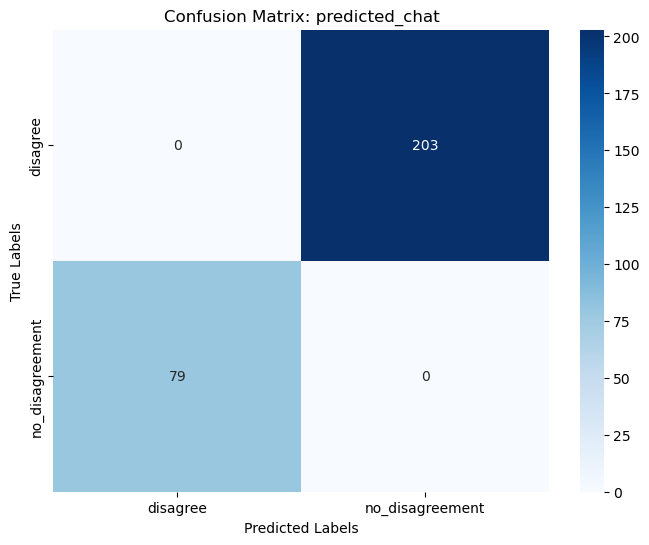

In [79]:
print_cm(errors_chat, 'predicted_chat')

**Findings**

* 203 / (282) = 0.7199 percent of the errors are predicted no_disagreement, when in fact it is disagreement

In [86]:
print((203 + 79))
print(203 / (203 + 79))

282
0.7198581560283688


label_2
disagree           232
no_disagreement     61
Name: count, dtype: int64


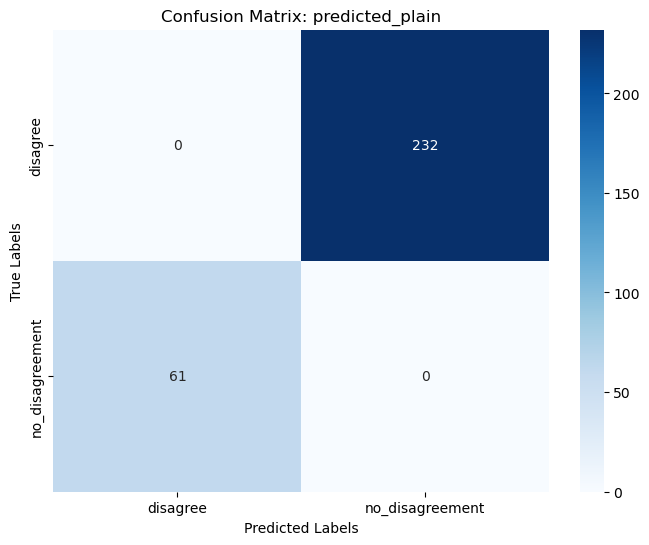

In [82]:
print_cm(errors_plain, 'predicted_plain')

label_2
disagree           152
no_disagreement    140
Name: count, dtype: int64


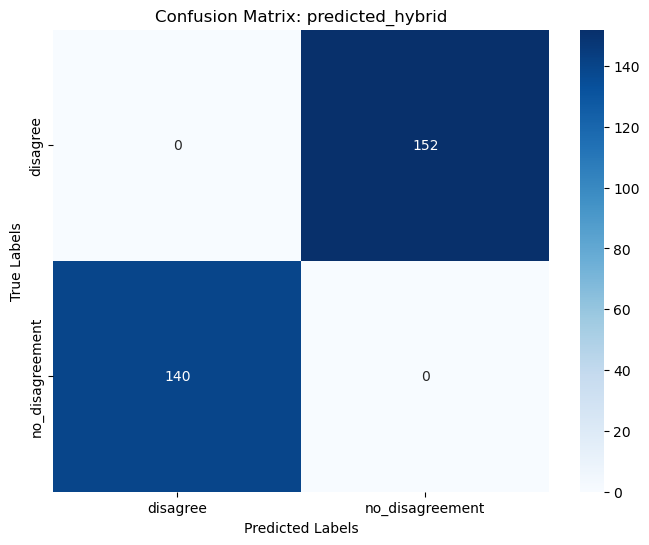

In [83]:
print_cm(errors_hybrid, 'predicted_hybrid')

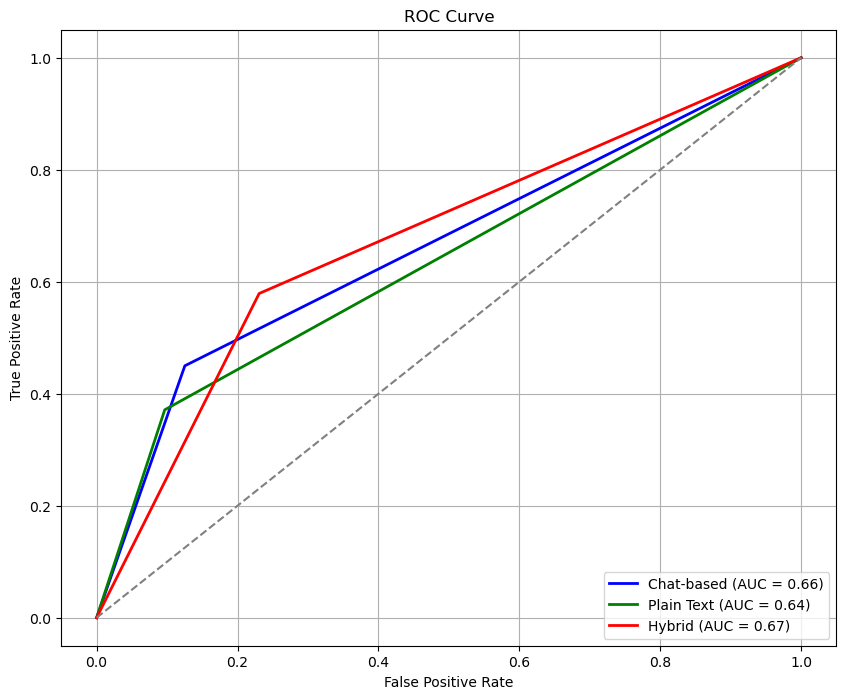

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert predictions to binary labels (0 and 1)
y_pred_chat = valid_chat['predicted_chat'].apply(lambda x: 1 if x == 'disagree' else 0)
y_pred_plain = valid_plain['predicted_plain'].apply(lambda x: 1 if x == 'disagree' else 0)
y_pred_hybrid = valid_hybrid['predicted_hybrid'].apply(lambda x: 1 if x == 'disagree' else 0)

y_true_chat = valid_chat['label_2'].apply(lambda x: 1 if x == 'disagree' else 0)
y_true_plain = valid_plain['label_2'].apply(lambda x: 1 if x == 'disagree' else 0)
y_true_hybrid = valid_hybrid['label_2'].apply(lambda x: 1 if x == 'disagree' else 0)


# Calculate ROC curve for each model
fpr_chat, tpr_chat, _ = roc_curve(y_true_chat, y_pred_chat)
fpr_plain, tpr_plain, _ = roc_curve(y_true_plain, y_pred_plain)
fpr_hybrid, tpr_hybrid, _ = roc_curve(y_true_hybrid, y_pred_hybrid)

# Calculate AUC (Area Under Curve) for each model
roc_auc_chat = auc(fpr_chat, tpr_chat)
roc_auc_plain = auc(fpr_plain, tpr_plain)
roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)

# Plot ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr_chat, tpr_chat, color='blue', lw=2, label=f'Chat-based (AUC = {roc_auc_chat:.2f})')
plt.plot(fpr_plain, tpr_plain, color='green', lw=2, label=f'Plain Text (AUC = {roc_auc_plain:.2f})')
plt.plot(fpr_hybrid, tpr_hybrid, color='red', lw=2, label=f'Hybrid (AUC = {roc_auc_hybrid:.2f})')

# Plotting diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Labels and title
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

# Show plot
plt.show()

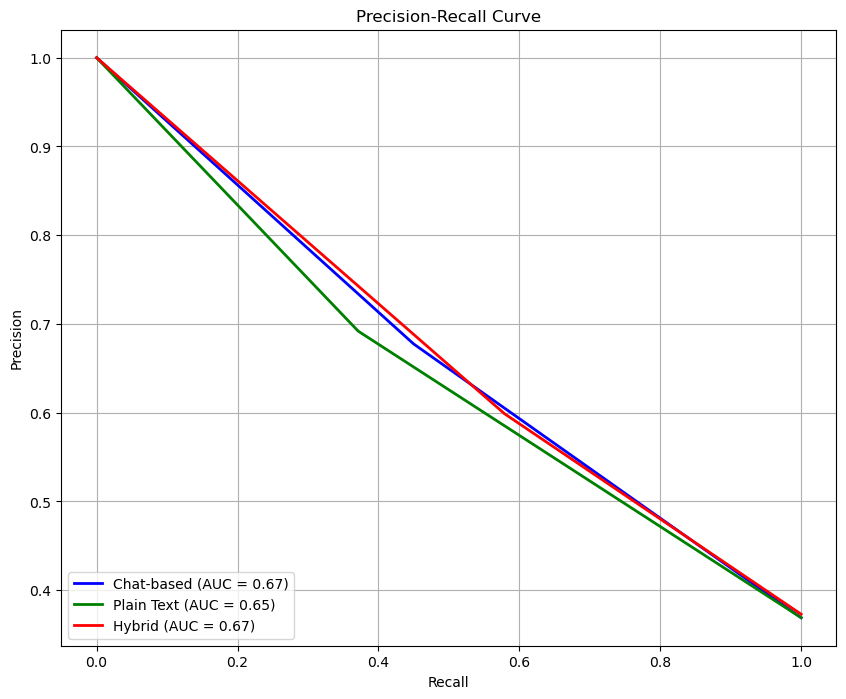

In [85]:

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# Assuming you already have y_true as the true labels (0 = 'no_disagreement', 1 = 'disagree')

# Convert predictions to binary labels (0 and 1)
y_pred_chat = valid_chat['predicted_chat'].apply(lambda x: 1 if x == 'disagree' else 0)
y_pred_plain = valid_plain['predicted_plain'].apply(lambda x: 1 if x == 'disagree' else 0)
y_pred_hybrid = valid_hybrid['predicted_hybrid'].apply(lambda x: 1 if x == 'disagree' else 0)

y_true_chat = valid_chat['label_2'].apply(lambda x: 1 if x == 'disagree' else 0)
y_true_plain = valid_plain['label_2'].apply(lambda x: 1 if x == 'disagree' else 0)
y_true_hybrid = valid_hybrid['label_2'].apply(lambda x: 1 if x == 'disagree' else 0)


# Calculate Precision-Recall curve for each model
precision_chat, recall_chat, _ = precision_recall_curve(y_true_chat, y_pred_chat, pos_label=1)
precision_plain, recall_plain, _ = precision_recall_curve(y_true_plain, y_pred_plain, pos_label=1)
precision_hybrid, recall_hybrid, _ = precision_recall_curve(y_true_hybrid, y_pred_hybrid, pos_label=1)

# Calculate AUC for Precision-Recall curve
pr_auc_chat = auc(recall_chat, precision_chat)
pr_auc_plain = auc(recall_plain, precision_plain)
pr_auc_hybrid = auc(recall_hybrid, precision_hybrid)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))

plt.plot(recall_chat, precision_chat, color='blue', lw=2, label=f'Chat-based (AUC = {pr_auc_chat:.2f})')
plt.plot(recall_plain, precision_plain, color='green', lw=2, label=f'Plain Text (AUC = {pr_auc_plain:.2f})')
plt.plot(recall_hybrid, precision_hybrid, color='red', lw=2, label=f'Hybrid (AUC = {pr_auc_hybrid:.2f})')

# Labels and title
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)

# Show plot
plt.show()
